# Sentiment Analysis

## 1. Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

## 2. Reading data

In [4]:
df = pd.read_parquet('cleaned_data/df_combined.parquet')

SENTIMENT ANALYSIS

In [41]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mateuszpliszka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mateuszpliszka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [42]:
# Create a new dataframe where there are no NA values for 'text_clean_en'
df_no_na = df[df['text_clean_en'].notna()]

# Display the first few rows of the new dataframe to verify
df_no_na.head()

,id,possibly_sensitive,in_reply_to_user_id,referenced_tweets,edit_controls,entities,text,public_metrics,edit_history_tweet_ids,reply_settings,...,text_clean,word_count,char_count,emoji_count,retweet_count,reply_count,like_count,quote_count,text_clean_en,text_clean_en_demojized
0,1.84626774302233e+18,False,509272614.0,"[{'type': 'replied_to', 'id': '184615588116918...","{'edits_remaining': 5, 'is_edit_eligible': Fal...","{'mentions': [{'start': 0, 'end': 15, 'usernam...","@Dariusz_Jonski ""Ani kroku wstecz!"" - w przód ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",[1846267743022330183],everyone,...,"""Ani kroku wstecz!"" - w przód też żadnego jak...",12,67,0,0,1,13,0,"""Not a step back!"" - you haven't put any forw...","""Not a step back!"" - you haven't put any forw..."
1,1.8462647773471176e+18,False,NaN,NaN,"{'edits_remaining': 5, 'is_edit_eligible': Tru...",NaN,Właśnie zadzwonił do mnie nieznany numer. Już ...,"{'retweet_count': 28, 'reply_count': 9, 'like_...",[1846264777347117471],everyone,...,Właśnie zadzwonił do mnie nieznany numer. Już ...,23,147,0,28,9,418,0,An unknown number just called me. I thought it...,An unknown number just called me. I thought it...
2,1.8462626933945882e+18,False,955239446.0,"[{'type': 'replied_to', 'id': '184612763211236...","{'edits_remaining': 5, 'is_edit_eligible': Fal...","{'mentions': [{'start': 0, 'end': 15, 'usernam...","@KosiniakKamysz Czy ""jeszcze cięższa praca"" pr...","{'retweet_count': 4, 'reply_count': 1, 'like_c...",[1846262693394588154],everyone,...,"Czy ""jeszcze cięższa praca"" przełoży się na r...",14,109,0,4,1,38,0,"Will ""even harder work"" translate into the fu...","Will ""even harder work"" translate into the fu..."
3,1.8462613413274463e+18,False,NaN,"[{'type': 'quoted', 'id': '1846159669573689602'}]","{'edits_remaining': 5, 'is_edit_eligible': Tru...","{'urls': [{'start': 45, 'end': 68, 'url': 'htt...",Polecam się zapoznać z treścią konferencji 👇 ...,"{'retweet_count': 9, 'reply_count': 2, 'like_c...",[1846261341327446163],everyone,...,Polecam się zapoznać z treścią konferencji 👇,7,47,1,9,2,48,0,I recommend reading the content of the confere...,I recommend reading the content of the confere...
4,1.8461048658290156e+18,False,NaN,NaN,"{'edits_remaining': 5, 'is_edit_eligible': Tru...","{'urls': [{'start': 277, 'end': 300, 'url': 'h...",❌ Kilka dni temu zagłosowałem za odwołaniem K...,"{'retweet_count': 30, 'reply_count': 0, 'like_...",[1846104865829015639],everyone,...,❌ Kilka dni temu zagłosowałem za odwołaniem K...,36,282,2,30,0,141,0,"❌ A few days ago, I voted to dismiss Krzysz...",":cross_mark: A few days ago, I voted to dis..."


In [43]:
res = {}

for i, row in tqdm(df_no_na.iterrows(), total=len(df_no_na)):
    text = row['text_clean_en_demojized']
    myID = row['id']
    res[myID] = sia.polarity_scores(text)


  0%|          | 0/11268 [00:00<?, ?it/s]

In [45]:
vader_res = pd.DataFrame.from_dict(res, orient='index').reset_index()

vader_res.rename(columns={'index': 'id'}, inplace=True)

vader_res.head()

,id,neg,neu,pos,compound
0,1.84626774302233e+18,0.000,1.000,0.000,0.0000
1,1.8462647773471176e+18,0.000,0.949,0.051,0.0772
2,1.8462626933945882e+18,0.000,0.867,0.133,0.3818
3,1.8462613413274463e+18,0.000,0.737,0.263,0.3612
4,1.8461048658290156e+18,0.161,0.803,0.036,-0.6705


In [46]:
vader_res.iloc[:, 1:5].mean()

neg         0.068183
neu         0.781232
pos         0.150496
compound    0.166108
dtype: float64

In [47]:
# Merge the values from vader_res to df_no_na by 'id'
df_no_na = df_no_na.merge(vader_res, on='id', how='left')

# Display the first few rows of the updated dataframe to verify the merge
df_no_na.head()

,id,possibly_sensitive,in_reply_to_user_id,referenced_tweets,edit_controls,entities,text,public_metrics,edit_history_tweet_ids,reply_settings,...,retweet_count,reply_count,like_count,quote_count,text_clean_en,text_clean_en_demojized,neg,neu,pos,compound
0,1.84626774302233e+18,False,509272614.0,"[{'type': 'replied_to', 'id': '184615588116918...","{'edits_remaining': 5, 'is_edit_eligible': Fal...","{'mentions': [{'start': 0, 'end': 15, 'usernam...","@Dariusz_Jonski ""Ani kroku wstecz!"" - w przód ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",[1846267743022330183],everyone,...,0,1,13,0,"""Not a step back!"" - you haven't put any forw...","""Not a step back!"" - you haven't put any forw...",0.000,1.000,0.000,0.0000
1,1.8462647773471176e+18,False,NaN,NaN,"{'edits_remaining': 5, 'is_edit_eligible': Tru...",NaN,Właśnie zadzwonił do mnie nieznany numer. Już ...,"{'retweet_count': 28, 'reply_count': 9, 'like_...",[1846264777347117471],everyone,...,28,9,418,0,An unknown number just called me. I thought it...,An unknown number just called me. I thought it...,0.000,0.949,0.051,0.0772
2,1.8462626933945882e+18,False,955239446.0,"[{'type': 'replied_to', 'id': '184612763211236...","{'edits_remaining': 5, 'is_edit_eligible': Fal...","{'mentions': [{'start': 0, 'end': 15, 'usernam...","@KosiniakKamysz Czy ""jeszcze cięższa praca"" pr...","{'retweet_count': 4, 'reply_count': 1, 'like_c...",[1846262693394588154],everyone,...,4,1,38,0,"Will ""even harder work"" translate into the fu...","Will ""even harder work"" translate into the fu...",0.000,0.867,0.133,0.3818
3,1.8462613413274463e+18,False,NaN,"[{'type': 'quoted', 'id': '1846159669573689602'}]","{'edits_remaining': 5, 'is_edit_eligible': Tru...","{'urls': [{'start': 45, 'end': 68, 'url': 'htt...",Polecam się zapoznać z treścią konferencji 👇 ...,"{'retweet_count': 9, 'reply_count': 2, 'like_c...",[1846261341327446163],everyone,...,9,2,48,0,I recommend reading the content of the confere...,I recommend reading the content of the confere...,0.000,0.737,0.263,0.3612
4,1.8461048658290156e+18,False,NaN,NaN,"{'edits_remaining': 5, 'is_edit_eligible': Tru...","{'urls': [{'start': 277, 'end': 300, 'url': 'h...",❌ Kilka dni temu zagłosowałem za odwołaniem K...,"{'retweet_count': 30, 'reply_count': 0, 'like_...",[1846104865829015639],everyone,...,30,0,141,0,"❌ A few days ago, I voted to dismiss Krzysz...",":cross_mark: A few days ago, I voted to dis...",0.161,0.803,0.036,-0.6705


In [48]:
# Group by party and calculate the mean of sentiment scores
sentiment_summary = df_no_na.groupby('party')[['neg', 'neu', 'pos', 'compound']].mean().reset_index()

# Display the sentiment summary
print(sentiment_summary)

    party       neg       neu       pos  compound
0   Konfa  0.073070  0.790602  0.136330  0.112379
1      NL  0.052763  0.796019  0.151207  0.226721
2     PIS  0.091994  0.794124  0.113882  0.023458
3  PL2050  0.048293  0.745998  0.205707  0.345603
4      PO  0.044884  0.754985  0.199630  0.294908
5     PSL  0.042397  0.768715  0.188879  0.402433


In [49]:
# Print the 10 posts with the highest negative sentiment values
top_negative_posts = df_no_na[df_no_na['word_count'] >= 3].nlargest(10, 'neg')[['id', 'text_clean_en', 'neg']]
print(top_negative_posts)

                          id  \
8913   1.798377262099923e+18   
8849  1.8104054846686006e+18   
3027  1.8028075109124465e+18   
6720  1.8074193914090127e+18   
5623  1.8284685389080456e+18   
7456  1.7987221916909568e+18   
600   1.7573868979056643e+18   
823   1.7187360763558344e+18   
3479  1.7186299120372372e+18   
9028  1.7598396933932365e+18   

                                          text_clean_en    neg  
8913                         Shamelessness and villainy  0.857  
8849   Search No. 2, The world of hatred, lies and v...  0.681  
3027                   The Internet takes no prisoners!  0.659  
6720               \n\nNasty government with no future.  0.659  
5623                                      Hate speech 👇  0.649  
7456                             A POLISH SOLDIER DIED.  0.643  
600       \n\nThere is no shortage of ignorant peopl...  0.640  
823                Unfortunately, it doesn't look good.  0.616  
3479            Stop mass and uncontrolled immigration!  0.600

Deleting rows with less than 3 words. Around 700 posts less.

In [50]:
# Filter the dataframe to include only rows where the 'text_clean_en' column has 3 words or more
df_filtered = df_no_na[df_no_na['text_clean_en'].apply(lambda x: len(str(x).split()) >= 3)]

# Display the first few rows of the new dataframe to verify
df_filtered.head()

,id,possibly_sensitive,in_reply_to_user_id,referenced_tweets,edit_controls,entities,text,public_metrics,edit_history_tweet_ids,reply_settings,...,retweet_count,reply_count,like_count,quote_count,text_clean_en,text_clean_en_demojized,neg,neu,pos,compound
0,1.84626774302233e+18,False,509272614.0,"[{'type': 'replied_to', 'id': '184615588116918...","{'edits_remaining': 5, 'is_edit_eligible': Fal...","{'mentions': [{'start': 0, 'end': 15, 'usernam...","@Dariusz_Jonski ""Ani kroku wstecz!"" - w przód ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",[1846267743022330183],everyone,...,0,1,13,0,"""Not a step back!"" - you haven't put any forw...","""Not a step back!"" - you haven't put any forw...",0.000,1.000,0.000,0.0000
1,1.8462647773471176e+18,False,NaN,NaN,"{'edits_remaining': 5, 'is_edit_eligible': Tru...",NaN,Właśnie zadzwonił do mnie nieznany numer. Już ...,"{'retweet_count': 28, 'reply_count': 9, 'like_...",[1846264777347117471],everyone,...,28,9,418,0,An unknown number just called me. I thought it...,An unknown number just called me. I thought it...,0.000,0.949,0.051,0.0772
2,1.8462626933945882e+18,False,955239446.0,"[{'type': 'replied_to', 'id': '184612763211236...","{'edits_remaining': 5, 'is_edit_eligible': Fal...","{'mentions': [{'start': 0, 'end': 15, 'usernam...","@KosiniakKamysz Czy ""jeszcze cięższa praca"" pr...","{'retweet_count': 4, 'reply_count': 1, 'like_c...",[1846262693394588154],everyone,...,4,1,38,0,"Will ""even harder work"" translate into the fu...","Will ""even harder work"" translate into the fu...",0.000,0.867,0.133,0.3818
3,1.8462613413274463e+18,False,NaN,"[{'type': 'quoted', 'id': '1846159669573689602'}]","{'edits_remaining': 5, 'is_edit_eligible': Tru...","{'urls': [{'start': 45, 'end': 68, 'url': 'htt...",Polecam się zapoznać z treścią konferencji 👇 ...,"{'retweet_count': 9, 'reply_count': 2, 'like_c...",[1846261341327446163],everyone,...,9,2,48,0,I recommend reading the content of the confere...,I recommend reading the content of the confere...,0.000,0.737,0.263,0.3612
4,1.8461048658290156e+18,False,NaN,NaN,"{'edits_remaining': 5, 'is_edit_eligible': Tru...","{'urls': [{'start': 277, 'end': 300, 'url': 'h...",❌ Kilka dni temu zagłosowałem za odwołaniem K...,"{'retweet_count': 30, 'reply_count': 0, 'like_...",[1846104865829015639],everyone,...,30,0,141,0,"❌ A few days ago, I voted to dismiss Krzysz...",":cross_mark: A few days ago, I voted to dis...",0.161,0.803,0.036,-0.6705


/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/109867607.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster'] = kmeans.labels_


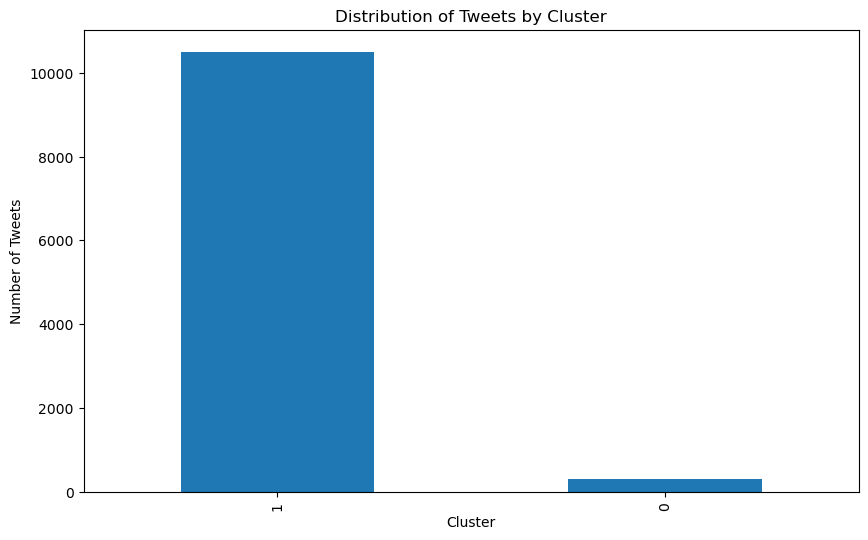

In [51]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_filtered['text_clean_en_demojized'].dropna())

# Perform KMeans clustering
num_clusters = 2  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add the cluster labels to the dataframe
df_filtered['cluster'] = kmeans.labels_

# Display the first few rows of the dataframe with cluster labels
df_filtered[['text_clean_en_demojized', 'cluster']].head()

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
df_filtered['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Cluster')
plt.show()

In [52]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax



def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
text = "Covid cases are increasing fast!"

text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# text = "Covid cases are increasing fast!"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1) negative 0.7236
2) neutral 0.2287
3) positive 0.0477


In [56]:
def bert_predict(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

In [53]:
df_filtered['text_bert'] = df_filtered['text_clean_en_demojized'].apply(preprocess)

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/274361585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['text_bert'] = df_filtered['text_clean_en_demojized'].apply(preprocess)


In [67]:
pd.set_option('display.max_colwidth', None)

df_filtered[['negative', 'neutral', 'positive']] = df_filtered['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))

df_filtered.iloc[0:9][['text_bert', 'negative', 'neutral', 'positive']]

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/3614085444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['negative', 'neutral', 'positive']] = df_filtered['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))


,text_bert,negative,neutral,positive
0,"""Not a step back!"" - you haven't put any forward either so far.",0.383399,0.542734,0.073867
1,An unknown number just called me. I thought it was the doctor who wanted to ask about my well-being.\n\nIt turned out that it was photovoltaics.,0.481302,0.484627,0.034071
2,"Will ""even harder work"" translate into the fulfillment of at least some of the election promises you made?",0.484032,0.475687,0.040281
3,I recommend reading the content of the conference :backhand_index_pointing_down:,0.012379,0.566814,0.420807
4,":cross_mark: A few days ago, I voted to dismiss Krzysztof Czabański from the position of member of the National Media Council.\n :backhand_index_pointing_right: It is worth reminding how unequal the fight we fought during the last parliamentary elections. \nApart from preventing the Confederation from accessing public media, it is difficult…",0.463204,0.519633,0.017163
5,"🇵 🇱 Another term of #PO and once again they are trying to block the #IndependenceMarch. If they do not go with us, we will go in spite of them! Just don't extinguish the spirit!",0.751366,0.231580,0.017054
6,":hear-no-evil_monkey: The propaganda of success has spread so much that even when they lose local elections to their own coalition partner, they feel like winners :see-no-evil_monkey:",0.402109,0.457339,0.140552
7,"On Sunday, October 13, at 3:45 p.m. in the Parish of Blessed Czesław in Opole at ul. Hallera 2, the Gietrzwałd Chapel was consecrated - one of 150 chapels built in Poland for the 150th anniversary of the Gietrzwałd apparitions.",0.006766,0.866456,0.126778
8,40 years have passed like one day! :revolving_hearts:,0.140323,0.404087,0.455589


In [70]:
# Calculate the average values for neg, neu, pos, compound, negative, neutral, and positive per party
sentiment_breakdown = df_filtered.groupby('party')[['neg', 'neu', 'pos', 'compound', 'negative', 'neutral', 'positive']].mean().reset_index()

# Display the sentiment breakdown
print(sentiment_breakdown)

    party       neg       neu       pos  compound  negative   neutral  \
0   Konfa  0.073926  0.796975  0.129101  0.110166  0.310858  0.412865   
1      NL  0.055219  0.797344  0.147425  0.230251  0.208479  0.358382   
2     PIS  0.093203  0.791847  0.114949  0.023650  0.414411  0.368972   
3  PL2050  0.049716  0.779960  0.170322  0.348035  0.162905  0.386512   
4      PO  0.047251  0.755426  0.197332  0.312095  0.171030  0.332379   
5     PSL  0.042197  0.778115  0.179679  0.408941  0.117255  0.352841   

   positive  
0  0.276277  
1  0.433139  
2  0.216617  
3  0.450583  
4  0.496591  
5  0.529904  


In [74]:
# Display the 10 most negative tweets
most_negative_tweets = df_filtered.nlargest(10, 'negative')[[ 'text_clean_en', 'negative']]
print("10 Most Negative Tweets:")
print(most_negative_tweets)

# Display the 10 most positive tweets
most_positive_tweets = df_filtered.nlargest(10, 'positive')[[ 'text_clean_en', 'positive']]
print("\n10 Most Positive Tweets:")
print(most_positive_tweets)

10 Most Negative Tweets:
                                                                                                                                                                                                    text_clean_en  \
6487                                                                     The economy is sinking, the judiciary is sinking, and Polish science is also sinking. The government losers are destroying the country.    
960   We have the worst tax system in the EU! It is not the fault of dwarves, beavers or the water vein in Poland. It is the fault of Polish parliamentarians who create this tax hell for Polish entrepreneurs!    
6587                                                                        These government losers do not protect Polish rivers and lakes. Hundreds of tons of dead fish! This power is like mercury for Poland.   
5518                                                                                                                       

In [76]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

text = "your text here"

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")


inputs = tokenizer(text, return_tensors="pt")
labels = torch.tensor([0])
outputs = model(**inputs, labels=labels)
loss, logits = outputs[:2]

# [0] -> left 
# [1] -> center
# [2] -> right
print(logits.softmax(dim=-1)[0].tolist())

model.safetensors:  19%|#9        | 83.9M/433M [00:00<?, ?B/s]

[0.22827006876468658, 0.29714715480804443, 0.47458282113075256]


In [77]:
def get_bias_score(text):
    inputs = tokenizer(text, return_tensors="pt")
    labels = torch.tensor([0])
    outputs = model(**inputs, labels=labels)
    loss, logits = outputs[:2]
    return logits.softmax(dim=-1)[0].tolist()   

In [79]:
df_filtered['text_bert_bias'] = df_filtered['text_clean_en_demojized'].apply(get_bias_score)

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/4054673994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['text_bert_bias'] = df_filtered['text_clean_en_demojized'].apply(get_bias_score)


In [80]:
# Extract values as left, center, right from 'text_bert_bias' column
df_filtered[['left', 'center', 'right']] = pd.DataFrame(df_filtered['text_bert_bias'].tolist(), index=df_filtered.index)

# Display the first few rows to verify the extraction
df_filtered[['text_clean_en_demojized', 'left', 'center', 'right']].head()

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/2714050964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['left', 'center', 'right']] = pd.DataFrame(df_filtered['text_bert_bias'].tolist(), index=df_filtered.index)
/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/2714050964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['left', 'center', 'right']] = pd.DataFrame(df_filtered['text_bert_bias'].tolist(), index=df_filtered.index)
/var/folders/4

,text_clean_en_demojized,left,center,right
0,"""Not a step back!"" - you haven't put any forward either so far.",0.305622,0.175898,0.518480
1,An unknown number just called me. I thought it was the doctor who wanted to ask about my well-being.\n\nIt turned out that it was photovoltaics.,0.251908,0.128170,0.619922
2,"Will ""even harder work"" translate into the fulfillment of at least some of the election promises you made?",0.397169,0.237391,0.365440
3,I recommend reading the content of the conference :backhand_index_pointing_down:,0.374031,0.158103,0.467865
4,":cross_mark: A few days ago, I voted to dismiss Krzysztof Czabański from the position of member of the National Media Council.\n :backhand_index_pointing_right: It is worth reminding how unequal the fight we fought during the last parliamentary elections. \nApart from preventing the Confederation from accessing public media, it is difficult…",0.317064,0.195270,0.487666


In [82]:
# Group by party and calculate the mean of sentiment scores and bias scores
sentiment_summary = df_filtered.groupby('party')[['neg', 'neu', 'pos', 'compound', 'negative', 'neutral', 'positive', 'left', 'center', 'right']].mean().reset_index()

# Group by party and calculate the total number of tweets
tweets_per_party = df_filtered['party'].value_counts().reset_index()
tweets_per_party.columns = ['party', 'total_tweets']

# Merge the sentiment summary with the total tweets per party
party_breakdown = sentiment_summary.merge(tweets_per_party, on='party')

# Display the party breakdown
print(party_breakdown)

    party       neg       neu       pos  compound  negative   neutral  \
0   Konfa  0.073926  0.796975  0.129101  0.110166  0.298641  0.268310   
1      NL  0.055219  0.797344  0.147425  0.230251  0.275133  0.304806   
2     PIS  0.093203  0.791847  0.114949  0.023650  0.310125  0.261677   
3  PL2050  0.049716  0.779960  0.170322  0.348035  0.284037  0.298830   
4      PO  0.047251  0.755426  0.197332  0.312095  0.301643  0.255524   
5     PSL  0.042197  0.778115  0.179679  0.408941  0.265065  0.353074   

   positive      left    center     right  total_tweets  
0  0.433049  0.298641  0.268310  0.433049          3390  
1  0.420061  0.275133  0.304806  0.420061           666  
2  0.428197  0.310125  0.261677  0.428197          3304  
3  0.417134  0.284037  0.298830  0.417134           553  
4  0.442834  0.301643  0.255524  0.442834          1791  
5  0.381861  0.265065  0.353074  0.381861          1096  


In [78]:
pd.set_option('display.max_colwidth', None)

df_filtered[['negative', 'neutral', 'positive']] = df_filtered['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))

df_filtered.iloc[0:9][['text_bert', 'negative', 'neutral', 'positive']]

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/3614085444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['negative', 'neutral', 'positive']] = df_filtered['text_bert'].apply(lambda x: pd.Series(bert_predict(x), index=['negative', 'neutral', 'positive']))


,text_bert,negative,neutral,positive
0,"""Not a step back!"" - you haven't put any forward either so far.",0.305622,0.175898,0.518480
1,An unknown number just called me. I thought it was the doctor who wanted to ask about my well-being.\n\nIt turned out that it was photovoltaics.,0.251908,0.128170,0.619922
2,"Will ""even harder work"" translate into the fulfillment of at least some of the election promises you made?",0.397169,0.237391,0.365440
3,I recommend reading the content of the conference :backhand_index_pointing_down:,0.374031,0.158103,0.467865
4,":cross_mark: A few days ago, I voted to dismiss Krzysztof Czabański from the position of member of the National Media Council.\n :backhand_index_pointing_right: It is worth reminding how unequal the fight we fought during the last parliamentary elections. \nApart from preventing the Confederation from accessing public media, it is difficult…",0.317064,0.195270,0.487666
5,"🇵 🇱 Another term of #PO and once again they are trying to block the #IndependenceMarch. If they do not go with us, we will go in spite of them! Just don't extinguish the spirit!",0.003154,0.994350,0.002496
6,":hear-no-evil_monkey: The propaganda of success has spread so much that even when they lose local elections to their own coalition partner, they feel like winners :see-no-evil_monkey:",0.337786,0.171170,0.491044
7,"On Sunday, October 13, at 3:45 p.m. in the Parish of Blessed Czesław in Opole at ul. Hallera 2, the Gietrzwałd Chapel was consecrated - one of 150 chapels built in Poland for the 150th anniversary of the Gietrzwałd apparitions.",0.247699,0.276148,0.476153
8,40 years have passed like one day! :revolving_hearts:,0.280994,0.202151,0.516855


CLUSTERING
1. TF-IDF VECTORIZATION 

In [83]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df_filtered['text_clean_en_demojized']).toarray()

Sentence transformer

In [86]:
from sentence_transformers import SentenceTransformer
import numpy as np
import time

st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df_filtered['encode_transforemers'] = df_filtered['text_clean_en_demojized'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df_filtered['encode_transforemers'])


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Elapsed time: 447.67 seconds


/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/4196125547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['encode_transforemers'] = df_filtered['text_clean_en_demojized'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())


In [94]:
%pip install torchtext.vocab

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement torchtext.vocab (from versions: none)
ERROR: No matching distribution found for torchtext.vocab
Note: you may need to restart the kernel to use updated packages.


In [95]:
from torchtext import GloVe

embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 100 
embedding_dim = 100

# define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

df_filtered['encode_glove'] = df_filtered['text_clean_en_demojized'].apply(lambda sentence: sentence_embedding(sentence))
X_glove = np.vstack(df['encode_glove'])

OSError: dlopen(/opt/anaconda3/lib/python3.12/site-packages/torchtext/lib/libtorchtext.so, 0x0006): Symbol not found: __ZN3c105ErrorC1ENSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEES7_PKv
  Referenced from: <7E3C8144-0701-3505-8587-6E953627B6AF> /opt/anaconda3/lib/python3.12/site-packages/torchtext/lib/libtorchtext.so
  Expected in:     <6A5B9A24-6538-3CC0-84A9-44E2C21B33A5> /opt/anaconda3/lib/python3.12/site-packages/torch/lib/libc10.dylib

In [97]:
from transformers import BertTokenizer, BertModel
import torch
import time

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

st = time.time()

df_filtered['cls_bert'] = df_filtered['text_clean_en_demojized'].apply(lambda sentence: get_cls_sentence(sentence))

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/3747821845.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cls_bert'] = df_filtered['text_clean_en_demojized'].apply(lambda sentence: get_cls_sentence(sentence))


Elapsed time: 360.09 seconds


KeyError: 'cls_bert'

In [98]:
X_cls_bert = np.vstack(df_filtered['cls_bert'])

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/76263465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'cluster_{title}'] = clusters


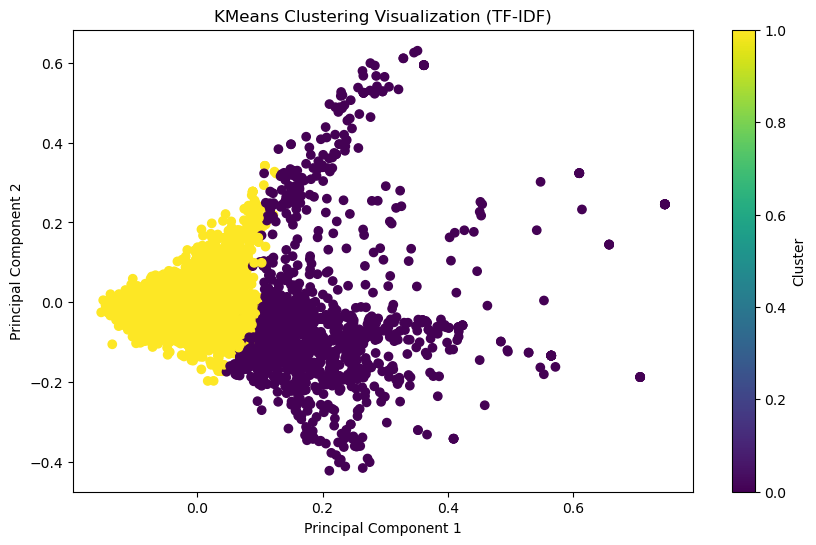

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/76263465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'cluster_{title}'] = clusters


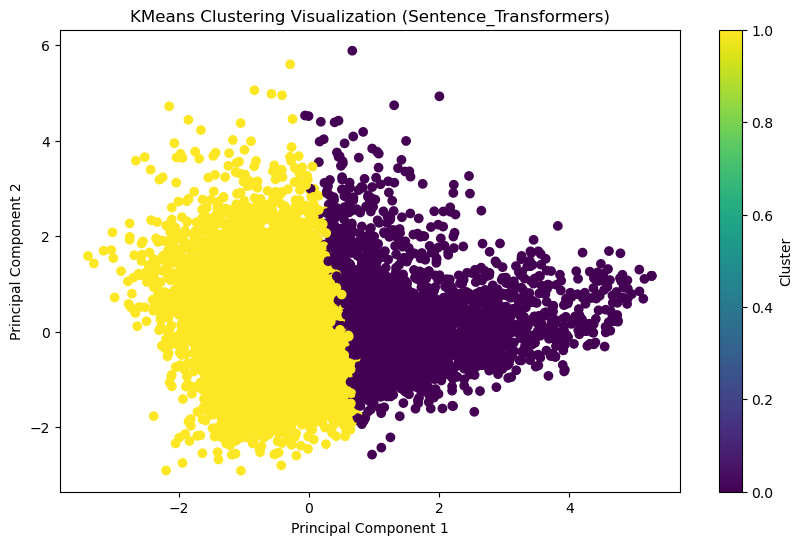

/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/76263465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'cluster_{title}'] = clusters


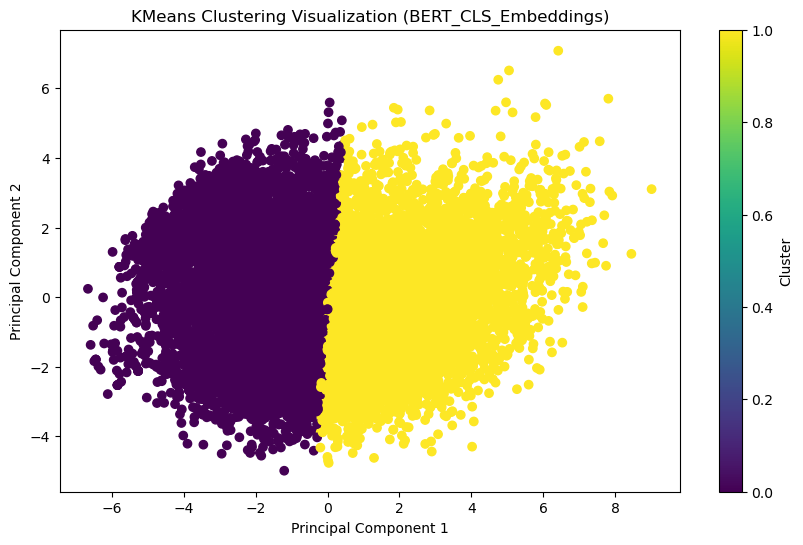

In [101]:
# Add cluster labels to the dataframe for each embedding method

import matplotlib.pyplot as plt

# Function to perform KMeans clustering and visualize the data
def kmeans_clustering_and_visualization(data, num_clusters=2, title=''):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    df_filtered[f'cluster_{title}'] = clusters
    # Perform PCA to reduce dimensions for visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.title(f'KMeans Clustering Visualization ({title})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

# Perform clustering and visualization on X
kmeans_clustering_and_visualization(X, num_clusters=2, title='TF-IDF')

# Perform clustering and visualization on X_transformers
kmeans_clustering_and_visualization(X_transformers, num_clusters=2, title='Sentence_Transformers')

# Perform clustering and visualization on X_cls_bert
kmeans_clustering_and_visualization(X_cls_bert, num_clusters=2, title='BERT_CLS_Embeddings')

In [103]:
# Create a new column 'opposition_proposition' where 1 indicates opposition and 0 indicates proposition
df_filtered['opposition_proposition'] = df_filtered['party'].apply(lambda x: 1 if x in ['Konfa', 'PIS'] else 0)

# Calculate the correlation between 'opposition_proposition' and 'cluster'
correlation = df_filtered['opposition_proposition'].corr(df_filtered['cluster_TF-IDF'])
correlation1 = df_filtered['opposition_proposition'].corr(df_filtered['cluster_Sentence_Transformers'])
correlation2 = df_filtered['opposition_proposition'].corr(df_filtered['cluster_BERT_CLS_Embeddings'])
correlation3 = df_filtered['opposition_proposition'].corr(df_filtered['cluster'])

print(f"Correlation between clusters and opposition/proposition: {correlation}")
print(f"Correlation between clusters and opposition/proposition: {correlation1}")
print(f"Correlation between clusters and opposition/proposition: {correlation2}")
print(f"Correlation between clusters and opposition/proposition: {correlation3}")

Correlation between clusters and opposition/proposition: 0.11507146525445289
Correlation between clusters and opposition/proposition: 0.14946047000550752
Correlation between clusters and opposition/proposition: 0.06324956589519347
Correlation between clusters and opposition/proposition: 0.1914493272387513


/var/folders/4y/59z3xr0d24q8s85gv4mfxhc00000gn/T/ipykernel_61169/839279828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['opposition_proposition'] = df_filtered['party'].apply(lambda x: 1 if x in ['Konfa', 'PIS'] else 0)


Zadania
Mati - uporządkować pliki 
     - sentyment reply, quote vs original
     - pokomentować
Łukasz - sprawdzic nowego berta